**FIR 滤波器设计**

#### FIR 滤波器与 IIR 滤波器的比较

与无限持续时间脉冲响应(IIR)滤波器相比，具有有限持续时间脉冲响应的数字滤波器（全零或 FIR 滤波器）既有优点又有缺点

FIR 滤波器具有以下主要优点：

- 它们可以具有精确的线性相位。
- 它们始终稳定。
- 设计方法通常是线性的。
- 它们可以在硬件中高效实现。
- 滤波器启动瞬态具有有限持续时间。

FIR 滤波器的主要缺点是，要达到同样的性能水平，其所需阶数远高于 IIR 滤波器。相应地，这些滤波器的延迟通常比同等性能的 IIR 滤波器大得多。

#### FIR 滤波器概述

下表描述了FIR滤波器的设计方法，和相应的Matlab,Python函数。

滤波器设计方法 | 说明 | Matlab滤波器设计函数 | Python滤波器设计函数
---------------|------|----------------------|--------------------
加窗 | 对指定的矩形滤波器的截断傅里叶逆变换应用加窗 | fir1, fir2, kaiserord | firwin, firwin2, kaiserord
多频带（包含过渡带） | 对频率范围的子带使用等波纹或最小二乘方法 | firls、firpm、firpmord | firls, remez
约束最小二乘 | 根据最大误差约束，在整个频率范围内最小化平方积分误差 | fircls, fircls1 | firls
任意响应 | 任意响应，包括非线性相位和复滤波器 | cfirpm | firls

#### 线性相位滤波器

除Matlab的cfirpm函数外，所有FIR滤波器设计函数都只设计线性相位滤波器。这些滤波器系数或“抽头”遵循偶数或奇数对称关系。根据这种对称性以及滤波器的阶数N是偶数还是奇数，线性相位滤波器（存储在长度为n +1的向量b中）对其频率响应有一定的固有限制。

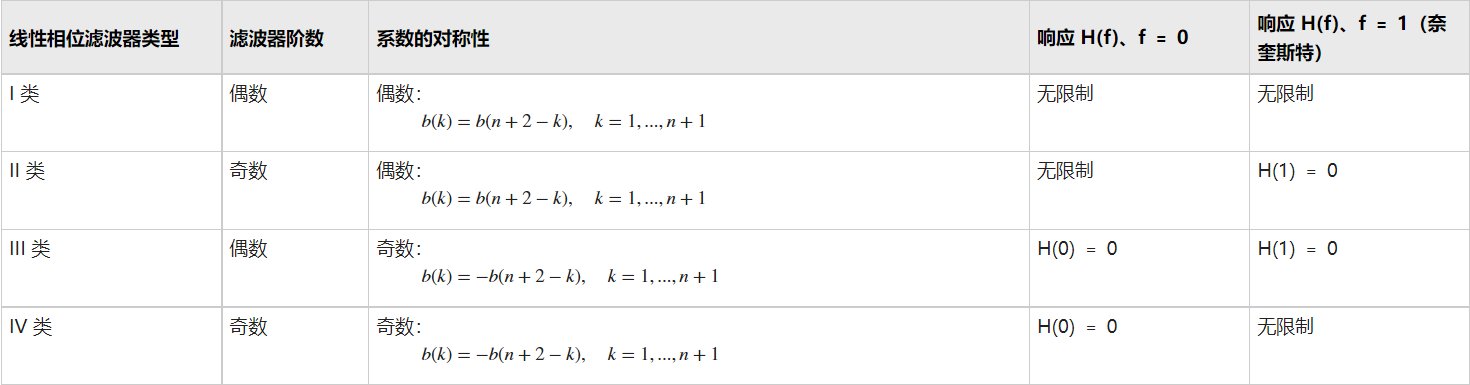

线性相位FIR滤波器的相位延迟和群延迟在整个频带内相等且恒定。对于N阶线性相位FIR滤波器，群延迟为N/2，滤波后的信号延迟N/2个时间步（其傅里叶变换的幅值按滤波器的幅值响应进行缩放）。该属性保持通带中信号的波形；也就是说，没有相位失真。

#### 加窗方法

假设一个截止频率为$\omega_0$弧度/秒的理想的矩形数字低通滤波器。该滤波器在幅值小于$\omega_0$的所有频率上都具有幅值1，在幅值介于$\omega_0$和$$之\pi间的频率上具有幅值0。其脉冲响应序列$h(n)$为

$$h(n)=\frac{1}{2\pi}\int_{-\pi}^{\pi}{H(\omega)e^{j\omega n}d\omega}=\frac{1}{2\pi}\int_{-\omega_0}^{\omega_0}{e^{j\omega n}d\omega}=\frac{sin{\omega_0n}}{\pi n}$$

该滤波器不可实现，因为它的脉冲响应是无限的和非因果的。要创建有限持续时间脉冲响应，请通过应用加窗来截断它。通过在此截断中保留脉冲响应的中心部分，可以获得线性相位FIR滤波器。例如，一个低通截止频率$\omega_0$为$0.4\pi$弧度/秒的、长度为51的滤波器为

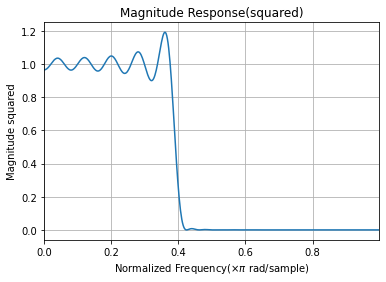

In [2]:
import numpy as np
from scipy import signal
from scipy import special
import matplotlib.pyplot as plt

b = 0.4*special.sinc(0.4*np.arange(-25,26))
w,h = signal.freqz(b,1)
fig,ax = plt.subplots()
ax.plot(w/np.pi,np.square(np.abs(h)));ax.grid()
ax.set_ylabel('Magnitude squared')
ax.set_xlabel('Normalized Frequency(×$\pi$ rad/sample)')
ax.set_title('Magnitude Response(squared)')
ax.autoscale(tight=True,axis='x')

此处应用的加窗是简单的矩形窗。根据**Parseval**定理，长度为51的滤波器在积分最小二乘意义上最接近理想的低通滤波器。

响应中会出现振铃和波纹，尤其是在频带边缘附近。这种“吉布斯效应”不会随着滤波器长度的增加而消失，但非矩形窗会减小其幅值。在时域中将信号乘以一个窗函数会使信号在频域中发生卷积或平滑。将长度为51的Hamming窗应用于滤波器，并显示结果：

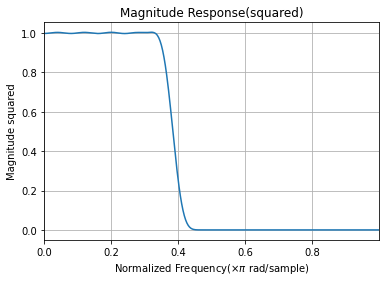

In [3]:
b = 0.4*special.sinc(0.4*np.arange(-25,26))
b = b*signal.windows.hamming(51)
w,h = signal.freqz(b,1)
fig,ax = plt.subplots()
ax.plot(w/np.pi,np.square(np.abs(h)));ax.grid()
ax.set_ylabel('Magnitude squared')
ax.set_xlabel('Normalized Frequency(×$\pi$ rad/sample)')
ax.set_title('Magnitude Response(squared)')
ax.autoscale(tight=True,axis='x')

使用`Hamming`窗可以大大降低振铃。这一改善以过渡带宽度和最优性为代价：加窗的滤波器需要更长时间从通带下降到阻带，且无法最小化平方误差积分。

1. 标准频带 FIR 滤波器设计

`fir1/firwin`使用最小二乘逼近计算滤波器系数，然后通过加窗对脉冲响应进行平滑处理。有关加窗及其属性的概述，请参阅加窗法。`fir1/firwin`类似于IIR滤波器的设计函数，因为它用于设计标准频带配置（低通、带通、高通和带阻）条件下的滤波器。

In [4]:
n = 51 #创建的是N=50阶的FIR滤波器
Wn = 0.4
b = signal.firwin(n,Wn)

此处创建变量b，其中包含N阶`Hamming`窗滤波器的系数。这是一个低通线性相位FIR滤波器，截止频率为Wn。Wn是介于0和1之间的数字，其中1对应于Nyquist频率，即采样频率的一半。（与其他方法不同，此处Wn对应于6dB点。）要获得高通滤波器，只需将`'high'/'highpass'`添加到函数的参数列表中。要获得带通或带阻滤波器，请将Wn指定为包含通带边缘频率的二元素向量。为带阻配置追加`'stop'/'stoppass'`。

**fir1/firwin**使用window参数中指定的窗口进行设计。向量window的长度必须为n+1个元素。如果未指定窗口，**fir1/firwin**将应用`Hamming`窗。

2. Kaiser 窗阶估计

**kaiserord**函数估计滤波器阶数、截止频率和Kaiser窗$\beta$参数(Python中有**kaiser_beta**函数估计$\beta$)，使之满足一组给定的滤波器设定。在给定频带边缘向量和对应的幅值向量以及最大允许波纹的情况下，`kaiserord`为**fir1**函数返回适当的输入参数。

3. 多频带FIR滤波器设计：fir2

**fir2/firwin2**函数还可用于设计加窗的FIR滤波器，但具有任意形状的分段线性频率响应。这与**fir1/firwin**不同，后者仅设计具有标准低通、高通、带通和带阻配置的滤波器。

In [6]:
n = 51 #创建的是N=50阶的FIR滤波器
f = np.array([0,0.4,0.5,1])
gain = np.array([1,1,0,0])
b = signal.firwin2(n,f,gain)

返回的变量b，其中包含N阶FIR滤波器的N+1个系数，其频率幅值特征与向量f和m给出的频率幅值特征相匹配。f是频率点的向量，范围从0到1，其中1代表Nyquist频率。m是向量，包含f中指定点的指定幅值响应。

#### 具有过渡带的多频带 FIR 滤波器设计

与**fir1/firwin**和**fir2/firwin2**函数相比，**firls**和**firpm/remez**函数提供更通用的指定理想滤波器的方法。这些函数用于设计Hilbert变换器、微分器和其他具有奇数对称系数（III类和IV类线性相位）的滤波器。它们还允许您包括误差没有最小化的过渡或“不重要”区域，并执行最小化的频带相关加权。

**firls**函数是**fir1/firwin**和**fir2/firwin2**函数的扩展，它用于最小化指定频率响应和实际频率响应之间误差平方的积分。

Matlab的**firpm**函数实现**Parks-McClellan**算法，该算法使用**Remez**交换算法和**Chebyshev**逼近理论来设计在指定频率响应和实际频率响应之间具有最佳拟合的滤波器。这种滤波器可最小化指定频率响应和实际频率响应之间的最大误差，从这种意义上而言，它们是最优的滤波器；它们有时被称为**minimax**滤波器。以这种方式设计的滤波器在频率响应方面表现出等波纹特性，因此也称为等波纹滤波器。**Parks-McClellan** FIR滤波器设计算法可能是最流行和最广泛使用的FIR滤波器设计方法。

Python中使用**Remez**交换算法计算有限冲激响应（FIR）滤波器的滤波器系数，可以得到**minimax**最优滤波器。该滤波器的传递函数使指定频带内的期望增益和实现增益之间的最大误差最小化。

**firls**和**firpm/remez**的语法相同；唯一的区别体现在最小化方案上。下一个示例说明用**firls**和**firpm/remez**设计的滤波器如何反映这些不同方案。

1. 基本配置

**firls**和**firpm/remez**的默认操作模式是设计I类或II类线性相位滤波器，具体取决于您所需的阶是偶数还是奇数。以下低通示例在0到0.4 Hz逼近幅值1，在0.5到1.0 Hz逼近幅值0：

In [7]:
n = 21 
f = np.array([0,0.4,0.5,1]) 
m = np.array([1,0]) 
b = signal.remez(n,f,m,Hz=2)

从0.4 Hz到0.5 Hz，**firpm/remez**不执行误差最小化；这是一个过渡带或“不重要”区域。过渡带将您关心的频带中的误差降至最低，但代价是过渡速率变慢。在这种方式下，这些类型的滤波器具有固有折衷，类似于加窗的FIR设计。

要将最小二乘与等波纹滤波器设计进行比较，请使用firls创建一个类似的滤波器：

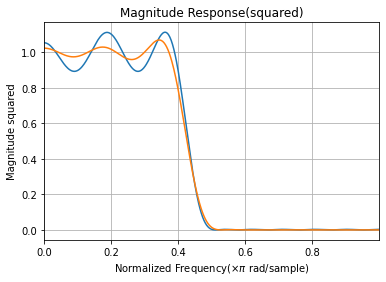

In [8]:
bb = signal.firls(n,f,np.array([1,1,0,0])) 
w1,h1 = signal.freqz(b,1)  
w2,h2 = signal.freqz(bb,1)  
fig,ax = plt.subplots()  
ax.plot(w1/np.pi,np.square(np.abs(h1))) 
ax.plot(w2/np.pi,np.square(np.abs(h2)));ax.grid()  
ax.set_ylabel('Magnitude squared')  
ax.set_xlabel('Normalized Frequency(×$\pi$ rad/sample)')  
ax.set_title('Magnitude Response(squared)')  
ax.autoscale(tight=True,axis='x')

使用**firpm/remez**设计的滤波器表现出等波纹行为。另请注意，**firls**滤波器在大部分通带和阻带上都有更好的响应，但在频带边缘（f = 0.4和f = 0.5）处，响应不如**firpm/remez**滤波器的响应理想。这表明，**firpm/remez**滤波器在通带和阻带上的最大误差较小，事实上，对于该频带边缘配置和滤波器长度来说，这是可能的最小值。

可以将频带视为短频率间隔内的线。**firpm/remez**和**firls**使用此方案来表示具有任何过渡带的任何分段线性频率响应函数。**firls**和**firpm/remez**用于设计低通、高通、带通和带阻滤波器；以下是一个带通示例，从技术上讲，这些f和a向量定义五个频带：

- 两个阻带，从0.0到0.3和从0.8到1.0；
- 一个通带，从0.4到0.7；
- 两个过渡带，从0.3到0.4和从0.7到0.8；

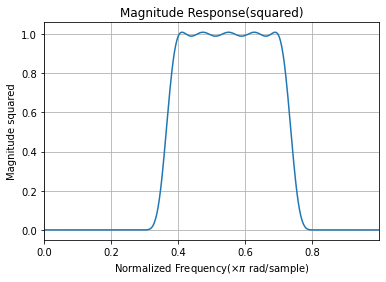

In [9]:
n = 51 #n表示点数，实际FIR滤波器的阶数为50
f = np.array([0,0.3,0.4,0.7,0.8,1]) 
m = np.array([0,1,0]) 
b = signal.remez(n,f,m,Hz=2) 
w,h = signal.freqz(b,1)  
fig,ax = plt.subplots()   
ax.plot(w/np.pi,np.square(np.abs(h)));ax.grid()   
ax.set_ylabel('Magnitude squared')   
ax.set_xlabel('Normalized Frequency(×$\pi$ rad/sample)')   
ax.set_title('Magnitude Response(squared)')   
ax.autoscale(tight=True,axis='x')

以下为高通和带阻滤波器的示例。

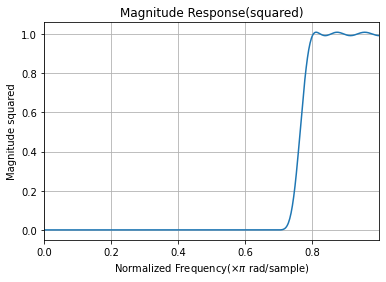

In [10]:
n = 51  
f = np.array([0,0.7,0.8,1])  
m = np.array([0,1])  
b = signal.remez(n,f,m,Hz=2)  
w,h = signal.freqz(b,1)   
fig,ax = plt.subplots()    
ax.plot(w/np.pi,np.square(np.abs(h)));ax.grid()    
ax.set_ylabel('Magnitude squared')    
ax.set_xlabel('Normalized Frequency(×$\pi$ rad/sample)')    
ax.set_title('Magnitude Response(squared)')    
ax.autoscale(tight=True,axis='x')

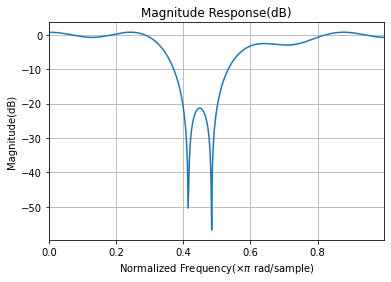

In [11]:
n = 17 
f = np.array([0,0.3,0.4,0.5,0.8,1])   
m = np.array([1,0,1])  
b = signal.remez(n,f,m,Hz=2)   
w,h = signal.freqz(b,1)    
fig,ax = plt.subplots()     
ax.plot(w/np.pi,20*np.log10(np.abs(h)));ax.grid()     
ax.set_ylabel('Magnitude(dB)')     
ax.set_xlabel('Normalized Frequency(×$\pi$ rad/sample)')     
ax.set_title('Magnitude Response(dB)')   
ax.autoscale(tight=True,axis='x')

以下是多频带带通滤波器的示例。

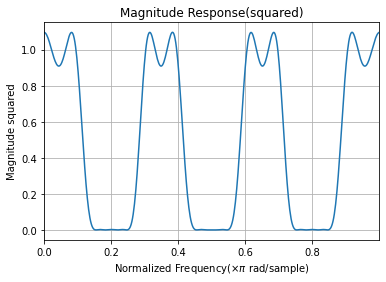

In [12]:
n = 51  
f = (np.array([0,0.1,0.15,0.25,0.3,0.4,0.45,0.55,0.6,0.7,0.75,0.85,0.9,1]))
m = np.array([1,0,1,0,1,0,1])   
b = signal.remez(n,f,m,Hz=2)    
w,h = signal.freqz(b,1)    
fig,ax = plt.subplots()     
ax.plot(w/np.pi,np.square(np.abs(h)));ax.grid()     
ax.set_ylabel('Magnitude squared')     
ax.set_xlabel('Normalized Frequency(×$\pi$ rad/sample)')     
ax.set_title('Magnitude Response(squared)')     
ax.autoscale(tight=True,axis='x')

2. 权重向量

**firls**和**firpm/remez**都允许您有所侧重地将某些频带的误差降至最低。为此，请在频率和幅值向量后指定权重向量。在以下低通等波纹滤波器示例中，阻带中的波纹比通带中的小10倍。

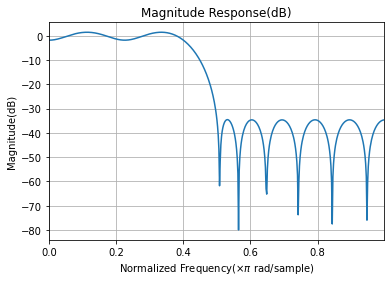

In [13]:
n = 21  
f = np.array([0,0.4,0.5,1])    
m = np.array([1,0])   
w = np.array([1,10])
b = signal.remez(n,f,m,w,Hz=2)    
w,h = signal.freqz(b,1)   
fig,ax = plt.subplots()    
ax.plot(w/np.pi,20*np.log10(np.abs(h)));ax.grid()    
ax.set_ylabel('Magnitude(dB)')    
ax.set_xlabel('Normalized Frequency(×$\pi$ rad/sample)')    
ax.set_title('Magnitude Response(dB)')    
ax.autoscale(tight=True,axis='x')

合法权重向量始终是f和a向量长度的一半；每个频带只能有一个对应权重。

3. 反对称滤波器/Hilbert 变换器

当用尾部`'h'`或`'Hilbert'`选项调用时，**firpm/remez**和**firls**会设计奇对称的FIR滤波器，即III类（偶数阶）或IV类（奇数阶）线性相位滤波器。理想的Hilbert变换器具有这种反对称属性，且在整个频率范围内幅值为1。尝试以下逼近Hilbert变换器，并对其绘图：

C:\Users\lenovo\AppData\Local\Temp/ipykernel_21112/4173026939.py:8: RuntimeWarning: divide by zero encountered in log10
  ax.plot(w1/np.pi,20*np.log10(np.abs(h1)),label='Highpass')
C:\Users\lenovo\AppData\Local\Temp/ipykernel_21112/4173026939.py:9: RuntimeWarning: divide by zero encountered in log10
  ax.plot(w2/np.pi,20*np.log10(np.abs(h2)),label='Bandpass')


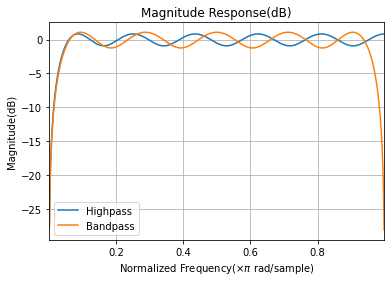

In [14]:
b = (signal.remez(22,np.array([0.05,1]),
np.array([1]),Hz=2,type='hilbert'))
bb = (signal.remez(21,np.array([0.05,0.95]),
np.array([1]),Hz=2,type='hilbert'))
w1,h1 = signal.freqz(b,1)
w2,h2 = signal.freqz(bb,1)
fig,ax = plt.subplots()    
ax.plot(w1/np.pi,20*np.log10(np.abs(h1)),label='Highpass')
ax.plot(w2/np.pi,20*np.log10(np.abs(h2)),label='Bandpass')
ax.grid();ax.legend()
ax.set_ylabel('Magnitude(dB)')    
ax.set_xlabel('Normalized Frequency(×$\pi$ rad/sample)')    
ax.set_title('Magnitude Response(dB)')    
ax.autoscale(tight=True,axis='x')

通过这些滤波器，您可以求得信号x的延迟Hilbert变换。

In [15]:
fs = 1000
t = np.arange(0,2+1/fs,1/fs)
x = np.sin(2*np.pi*300*t)
zi = signal.lfilter_zi(bb,1)*0
xh,_ = signal.lfilter(bb,1,x,zi=zi)

对应于x的分析信号是以x为实部、以x的Hilbert变换为虚部的复信号。对于这种FIR方法（hilbert函数的替代方法），您必须将x延迟一半滤波器阶数才能创建分析信号：

In [16]:
xd = np.hstack((np.zeros(10),x[:len(x)-10]))
xa = xd+xh*(1j)

这种方法不能直接用于奇数阶滤波器，因为奇数阶滤波器需要非整数延迟。在这种情况下，Hilbert变换中所述的hilbert函数可估算解析信号。或者，使用**resample**函数将信号延迟非整数个样本。

4. 微分器

信号在时域中的微分等效于信号的傅里叶变换乘以虚斜坡函数。也就是说，要对信号求导，请将其传递给具有响应$H(\omega)=j\omega$的滤波器。使用**firpm/remez**或**firls**和`'d'`或`'differentiator'`选项逼近理想的微分器（有延迟）：

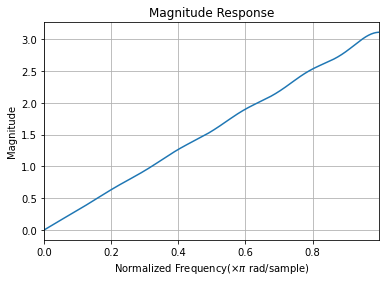

In [17]:
b = (signal.remez(22,np.array([0,1]),np.array([2*np.pi]),
Hz=2,type='differentiator'))
w,h = signal.freqz(b,1)
fig,ax = plt.subplots()    
ax.plot(w/np.pi,np.abs(h));ax.grid()
ax.set_ylabel('Magnitude')    
ax.set_xlabel('Normalized Frequency(×$\pi$ rad/sample)')    
ax.set_title('Magnitude Response')    
ax.autoscale(tight=True,axis='x')

对于III类滤波器，微分频带不应超过Nyquist频率，幅值向量必须反映此变化，以确保斜率正确：

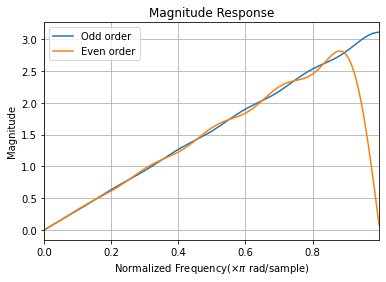

In [18]:
bb = (signal.remez(21,np.array([0,0.9]),np.array([2*np.pi]),
Hz=2,type='differentiator'))
w1,h1 = signal.freqz(bb,1)
fig,ax = plt.subplots()
ax.plot(w/np.pi,np.abs(h),label='Odd order')
ax.plot(w1/np.pi,np.abs(h1),label='Even order')
ax.grid();ax.legend()
ax.set_ylabel('Magnitude')    
ax.set_xlabel('Normalized Frequency(×$\pi$ rad/sample)')    
ax.set_title('Magnitude Response')    
ax.autoscale(tight=True,axis='x')

在`'d'`模式下，**firpm/remez**在非零幅值频带中对误差加权，以最小化最大相对误差。在`'d'`模式下，**firls/remez**在非零幅值频带中对误差加权。